In [1]:
import numpy as np
import random
from collections import defaultdict
import warnings
from datetime import datetime, date
from functools import partial

import pandas as pd
import holidays
import matplotlib.pyplot as plt
from scipy.stats import zscore
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from scipy import stats
from sklearn.preprocessing import normalize

us_holidays = holidays.UnitedStates()
warnings.simplefilter(action="ignore", category=FutureWarning)
plt.style.use("fivethirtyeight")
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
pd.options.mode.chained_assignment = None


# Top-level Summary 
- **Modeling algorithm:**  I used `xgboost` to forecast ridership in December, because it is fast, because feature engineering is simple to execute, and also because we may encode the near-term behaviors that characterize more traditional time series models in xgboost as lag features.
- **Metrics:** I used used `R^2` for the purpose of optimizing model performance in a normalized fashion, but for the purpose of communicating results, `mean absolute error` may be preferable for because of its interpretability, especially when it is normalized by average ridership per day.
- **Results of modeling:** I forecasted December 2016 ridership entry over all stations with 5 different models, in order to illustrate the necessity of anomaly removal for any kind of predictive performance, and  to show the advantages of including 2015 data and holiday features. I then forecasted ridership for stations using two different models. In the by-station case, the model tends to overfit on the station feature, and consequently performs better on near-term data; I suggest solutions below. The best model across all stations had an `R^2` of `.96`, and a mean absolute error of `214,397` entries, for a normalized error of `4.37%`. The best model for the by station forecast had an `R^2` of `.86` and a mean absolute error of `2044` entries, for a normalized error of `21.89%`. There is a important caveat to the high `R^2` scores in how I chose to handle anomalies.
- **Anomalies:** The model performance is highly sensitive to the threshold of outlier removal. I show how poorly a model that is not cleansed of anomalous data performs (model #1). For the rest of the models, I  chose to remove anomalies from both the test (December 2016) and training sets because I reasoned that measuring performance against an anomalous test set would not illustrate how well the model predicts true data. Thus, the results should be interpreted as: how does the model perform on a test set which is not (as) anomalous, i.e., which is closer to the true distribution?
- **Augmentation of data sources:** I chose to include a holiday (and lag day holiday) feature, after seeing that the model performed most poorly around Christmas. I also augmented the data with 2015 data, as I expected to see yearly seasonality.

# Outline
- *Problem Statement*
- *Data Loading, Processing, and Exploration*
    - Data issues
    - Anomaly removal
    - Understanding the data from a time series POV
- *Modeling Using `xgboost`*
    - Across all stations
    - By station
- *Conclusion* 


# Problem statement
1. Using January to November as a training set, we wish to step through every day in
December, and using all data prior to that date, forecast the total number of entries on
that day. Ensure that you do whatever data cleaning and filtering is necessary. What is
the most appropriate metric for evaluating success?
2. Similar to 1, forecast turnstile entries for every station individually for every day in
December. Is this problem easier or harder than forecasting for the system as a whole?
3. Augment your solution to 2. With whatever external data (one or two sources) you think
is most appropriate. Explain why you think this data would be useful in predicting
ridership and the improvement in predictive accuracy

# Data Loading, Processing, and Exploration

First, I loaded the turnstile data. The columns needed to be standardized, both with respect to date and data type. Then I saved the dataframes to serialized (pickled) objects, for faster loading on future iterations. 

Note that I loaded in the 2015 turnstile dataset as well. Together with the "is holiday" feature, this answers the question of how I would enhance the dataset to make better predictions. (I augmented the 2015 dataset because it could help account for yearly seasonality trends. I added the "is holiday" feature because I noticed lower ridership on holidays and surrounding days.)

I will separate the 2016 data (`df_2016`), from the 2016 data augmented with 2015 data (`df_aug`), so that I can later show the advantages of including augmentation.

In [2]:
# Contents of the corresponding requirements file. Can create a virtual environment and install 
# via pip install -r requirements.txt.

!cat requirements.txt

matplotlib==3.1.0
numpy==1.16.4
pandas==0.24.2
scipy==1.3.0
holidays==0.9.11
xgboost==0.90
scikit_learn==0.21.3


In [3]:
def load_turnstile_data(file):
    """
    Loads turnstile data the local file. Input is a string to the csv file, output is the
    dataframe of the data. 
    """
    def dateparse(d,t):
        dt = d + " " + t
        return pd.datetime.strptime(dt, '%m/%d/%Y %H:%M:%S')
    
    def clean_column_names(df):
        return df.rename(columns=lambda x: x.strip().lower().replace(' ', '_'))

    headers = ['C/A', 'Unit', 'SCP', 'Station', 'Line Name', 'Division', 'Date', 
               'Time', 'Description', 'Entries', 'Exits']
    dtypes = {x:'str' for x in headers if x not in ['Entries', 'Exits']}
    dtypes['Entries'] = 'int'
    dtypes['Exits'] = 'int'
    df = pd.read_csv(file, header=None, names=headers, dtype=dtypes,skiprows=1,
                     parse_dates={'Datetime': ['Date', 'Time']}, date_parser=dateparse)
    df = clean_column_names(df)
    
    # Problem statement is about entries, so I will drop exits
    df = df.drop('exits', axis=1)
    
    return df

# Commenting out once the data has been saved:
"""
file_2016 = '/Users/rachel/Downloads/Turnstile_Usage_Data__2016.csv'
df_2016 = load_turnstile_data(file_2016)
df_2016.to_pickle('turnstile_data_2016.pkl')

file_2015 = '/Users/rachel/Downloads/Turnstile_Usage_Data__2015.csv'
df_2015 = load_turnstile_data(file_2015)
df_2015.to_pickle('turnstile_data_2015.pkl')
"""

"\nfile_2016 = '/Users/rachel/Downloads/Turnstile_Usage_Data__2016.csv'\ndf_2016 = load_turnstile_data(file_2016)\ndf_2016.to_pickle('turnstile_data_2016.pkl')\n\nfile_2015 = '/Users/rachel/Downloads/Turnstile_Usage_Data__2015.csv'\ndf_2015 = load_turnstile_data(file_2015)\ndf_2015.to_pickle('turnstile_data_2015.pkl')\n"

In [4]:
# Loading previously serialized data

df_2015 = pd.read_pickle('turnstile_data_2015.pkl')
df_2016 = pd.read_pickle('turnstile_data_2016.pkl')

In [5]:
initial_2015_rows = df_2015.shape[0]
initial_2016_rows = df_2016.shape[0]

print(f"The 2015 data have {initial_2015_rows} rows, while  the 2016 data have {initial_2016_rows} rows.")

The 2015 data have 9947131 rows, while  the 2016 data have 9492670 rows.


Before we do further preprocessing, we take a peek at the dataframe. It shows the entries and exits per turnstile at each timestamp. 

In [6]:
df_2016.head()

,datetime,c/a,unit,scp,station,line_name,division,description,entries,exits
0,2016-12-30 23:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5991455,2028368
1,2016-12-30 19:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5991003,2028335
2,2016-12-30 15:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5989931,2028277
3,2016-12-30 07:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5989153,2028014
4,2016-12-30 03:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,5989126,2027972


I'll reserve df_2016 to show performance on the 2016 dataset. To show improved performance on the combined dataset, I'll define:

In [7]:
df_aug =  pd.concat([df_2015, df_2016], axis=0)

In [8]:
df_aug.shape[0], df_2016.shape[0]

(19439801, 9492670)

There are duplicate rows, so I'll remove those:

In [9]:
df_2016.drop_duplicates(inplace = True)
df_aug.drop_duplicates(inplace = True)

In [10]:
df_aug.shape[0], df_2016.shape[0]

(18800508, 9297894)

## Further Issues with the Data

As I explored the data, I noticed some issues:

* There are missing days.

*Solution: I will leave the days missing, and not impute directly. Imputation will happen indirectly later with lag and rolling mean columns for the days that are present in the data.*

* The turnstile is not straightforwardly defined as a column.

*Solution: I'll define each turnstile as a concatenation of concatenation of c/a, unit, scp, station, line_name and division.*


* Similarly, the station line is a string name, but two different stations may have the same name with have different lines running through them.

*Solution: Concatenate station name and lines.*

* For each turnstile (as I previously defined it), the station entries are cumulative and ascending, though we would have liked the entries column to represent new entries since last timestamp. 

*Solution: Sort by date, group by turnstile, and take consecutive differences.*

* Sometimes, a ceiling is hit and the counter restarts. The ceiling is not uniform across turnstiles, and not every turnstile has one. Furthermore, the counter sometimes descends.

*Solution: Drop negative differences. The data is be large enough to accomodate this.*


* There are many anomalies in the differences as well as the absolute number, which are not supported by any common sense reasoning.

*Solution: Introduce outlier removal by z-score, and apply to differences as well as the absolute number of entries. This was the quick and dirty approach that lead to high model performance, but I would like to make this more rigorous in the future.*

* The timestamps are not uniform across turnstiles.

*Solution: Project timestamps to nearest 6 hour window. Implemented in the code below as an optional feature for `add_features_for_preprocessing` and `get_differences`. The processing is too slow on my computer, and it was therefore not used; instead, it should be implemented on `Spark` on a cloud cluster.*

* Some turnstile sensors appear to be broken, with 0 ridership over large periods of time.

*Solution: Future scope would involve finding public data on station closures. Then if a station is not closed, and there is 0 ridership for some significant amount of time, we could define it as broken.*

In [11]:
def add_features_for_preprocessing(df, round_timestamps = False):
    """
    Given a dataframe, augment the dataframe with datetime features,
    and encode turnstiles and station lines.
    """
    
    # Datetime processing
    df['date'] = df.datetime.dt.date
    
    # Optional: round the timestamps to 4 different timestamps. Not displayed in the current
    # notebook because run time is too slow, but is useful for anomaly removal.
    if round_timestamps:
        df['time'] = df.datetime.dt.time
        # Round timestamps to every 6 hours
        turn_timestamps = [get_time("00:00:00"),
                           get_time("06:00:00"),
                           get_time("12:00:00"),
                           get_time("18:00:00")]
        def subtract_time(x, y):
            return datetime.combine(date.today(), x) - datetime.combine(date.today(), y)
        def nearest(items, pivot):
            return min(items, key=lambda x: abs(subtract_time(x,pivot)))
        nearest_time = partial(nearest, turn_timestamps)
        df_aug_test['time'] = df_aug_test['time'].apply(nearest_time)

    # Turnstile names defined as a concatenations of the columns below
    df['ts'] = df['c/a'].astype(str) + \
                    df['unit'].astype(str) + \
                    df['scp'].astype(str) + \
                    df['station'].astype(str)  + \
                    df['line_name'].astype(str) + \
                    df['division'].astype(str) 
    
    # Station names defined as station name plus line name
    df['station_line'] = df['station'].astype(str)  + \
                    df['line_name'].astype(str)
    
    df = encode_features(df, 'station_line')
    df = encode_features(df, 'ts')
    
    # We won't be using these anymore
    df.drop(['c/a', 'unit', 'scp', 'station',
             'line_name', 'division', 'station_line',
             'ts', 'description'],
            axis=1,
            inplace=True)

def encode_features(df, column_to_encode):
    """
    Given a dataframe and a column to encode, encodes the values in the column as integers,
    adds a column for the encoding, and returns the dataframe.
    """
    def encoding_dict(set_of_strings):
        encoding_dict = defaultdict(int)
        for i,j in enumerate(list(set_of_strings)):
            encoding_dict[j]= i
        return encoding_dict
    
    name = column_to_encode + "_id"
    enc_dict = encoding_dict(set(df[column_to_encode]))
    df[name] = [enc_dict[x] for x in df[column_to_encode]]
    return df

In [12]:
add_features_for_preprocessing(df_2016)
add_features_for_preprocessing(df_aug)

Let's peek at the data after preprocessing. For each encoded station (`station_line_id`), each encoded turnstile (`ts_id`) and timestamp, entries and exits are shown.

In [13]:
df_aug.head()

,datetime,entries,exits,date,station_line_id,ts_id
0,2016-01-01 23:00:00,5478127,1849126,2016-01-01,120,7153
1,2016-01-01 19:00:00,5477962,1849103,2016-01-01,120,7153
2,2016-01-01 15:00:00,5477676,1849053,2016-01-01,120,7153
3,2016-01-01 11:00:00,5477548,1848989,2016-01-01,120,7153
4,2016-01-01 07:00:00,5477508,1848946,2016-01-01,120,7153


In [14]:
df_aug.shape

(18800508, 6)

In [15]:
df_aug.describe()

,entries,exits,station_line_id,ts_id
count,1.880051e+07,1.880051e+07,1.880051e+07,1.880051e+07
mean,3.238670e+07,2.599932e+07,3.500052e+02,3.608076e+03
std,1.866699e+08,1.673706e+08,2.065931e+02,2.081673e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.278840e+05,2.793400e+05,1.770000e+02,1.819000e+03
50%,2.455996e+06,1.448202e+06,3.470000e+02,3.606000e+03
75%,6.260024e+06,4.490518e+06,5.150000e+02,5.421000e+03
max,2.147480e+09,2.097170e+09,7.320000e+02,7.214000e+03


While there are no missing values from the data that are in the dataframe, I noticed that there were missing dates in the training set, computed below. I cross-checked with the UI on the NYC Data site to confirm that they are indeed missing there as well, and that it is not an error in my method of data loading.

In particular, there are missing days in December 2016. They are: '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-31'. Thus the day-by-day forecasting approach suggested in the problem statement does not apply in a literal way. Below, I will forecast for all days in December present in the set, and then explain how to modify for a more day-by-day approach.

In [16]:
# Computation for missing days
missing_days = list(set(pd.date_range("01-01-2015", "12-31-2016").date)
                    .symmetric_difference(set(df_aug.date.unique())))
missing_days.sort()
print([str(x) for x in missing_days])

['2015-10-24', '2015-10-25', '2015-10-26', '2015-10-27', '2015-10-28', '2015-10-29', '2015-10-30', '2015-11-07', '2015-11-08', '2015-11-09', '2015-11-10', '2015-11-11', '2015-11-12', '2015-11-13', '2015-11-21', '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26', '2015-11-27', '2016-06-04', '2016-06-05', '2016-06-06', '2016-06-07', '2016-06-08', '2016-06-09', '2016-06-10', '2016-06-11', '2016-06-12', '2016-06-13', '2016-06-14', '2016-06-15', '2016-06-16', '2016-06-17', '2016-07-02', '2016-07-03', '2016-07-04', '2016-07-05', '2016-07-06', '2016-07-07', '2016-07-08', '2016-12-10', '2016-12-11', '2016-12-12', '2016-12-13', '2016-12-14', '2016-12-15', '2016-12-16', '2016-12-31']


In [17]:
"Overall, there are {} missing days from the augmented (2015/2016) training set".format(len(missing_days)) 

'Overall, there are 50 missing days from the augmented (2015/2016) training set'

In [18]:
print("There are " + str(len(df_2016.ts_id.unique())) + " unique turnstiles in 2016 and " + str(len(df_aug.ts_id.unique())) + " turnstiles for both years.")

There are 5175 unique turnstiles in 2016 and 7215 turnstiles for both years.


The features are now clean and ready for further preprocessing. I'll now create a new column of differences and  remove negative ones, as well as the missing ones (which are expected for each `ts_id` (turnstile id), considering how differences are calculated).

In [19]:
def get_differences(df, round_timestamps = False):
    """
    Given a dataframe, get differences of consecutive columns for entries after sorting,
    and remove the rows with missing values that result from the process. Return the df.
    """
    df.sort_values(['ts_id','datetime'], inplace=True)
    
    df['diff_entry'] = df.groupby('ts_id', as_index=False)['entries'].diff().reset_index(level=0, drop=True)
    
    bad_columns_entries = round(len(df[(df.diff_entry < 0) | (df.diff_entry.isna())  ]) / df.shape[0], 3)
    print(f"{bad_columns_entries} percent of entries removed during differences process")

    df = df[~(df.diff_entry < 0) & ~(df.diff_entry.isna()) ]
    df.dropna(inplace=True)
    
    if round_timestamps:
        # The timestamp normalization step creates duplicate entries that should be summed
        cols = [x for x in df.columns if x != 'diff_entry']
        df = df.groupby(cols, as_index=False)['diff_entry'].sum()

    return df

In [20]:
df_2016 = get_differences(df_2016)
df_aug = get_differences(df_aug)

0.008 percent of entries removed during differences process
0.007 percent of entries removed during differences process


In [21]:
df_aug.head()

,datetime,entries,exits,date,station_line_id,ts_id,diff_entry
2345888,2015-01-01 07:00:00,42338,15738,2015-01-01,135,0,4.0
2345886,2015-01-01 11:00:00,42382,15747,2015-01-01,135,0,44.0
2345884,2015-01-01 15:00:00,42573,15788,2015-01-01,135,0,191.0
2345882,2015-01-01 19:00:00,42796,15841,2015-01-01,135,0,223.0
2345880,2015-01-01 23:00:00,42870,15889,2015-01-01,135,0,74.0


## Further Anomaly Discussion 

In the previous step, I already removed some anomalies, corresponding to counter resets and descending (rather than ascending) counts. Let's look at the distribution of the difference data to see if there are more to be removed. 

In [22]:
def boxplot(array):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bp = ax.boxplot(array)

In [23]:
def hist(df, column, title, xlabel, ylabel):
    fig, axes = plt.subplots()
    df.hist(column=column, bins=100, ax=axes)
    plt.title(title)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

In [24]:
def get_date(date_string):
    return pd.to_datetime(date_string).date()

Observe that the data have many large values outside the third quartile: 

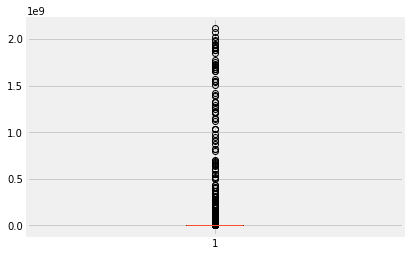

In [25]:
boxplot(df_aug.diff_entry)

In [26]:
Q1 = df_aug.diff_entry.quantile(0.25)
Q3 = df_aug.diff_entry.quantile(0.75)
IQR = Q3 - Q1
print(f"The interquartile range for consecutive differences is {IQR}.")

The interquartile range for consecutive differences is 238.0.


In [27]:
IQ_rem = df_aug[~((df_aug.diff_entry < (Q1 - IQR)) |(df_aug.diff_entry > (Q3 + IQR)))]
print("The data (augmented) have {}".format(df_aug.shape[0]) + " rows, but after removing outer quartiles, there are {} rows".format(IQ_rem.shape[0]))

The data (augmented) have 18672364 rows, but after removing outer quartiles, there are 16701383 rows


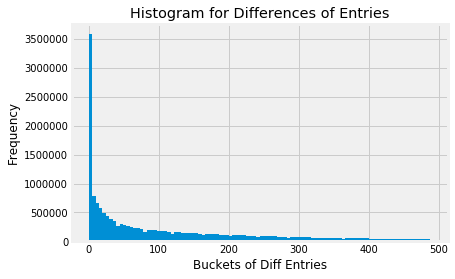

In [28]:
hist(IQ_rem,
     'diff_entry',
     'Histogram for Differences of Entries',
     'Buckets of Diff Entries',
     'Frequency')

After removing the points outside the quartiles, we observe an approximate exponential distribution. However, there are many points at 0, which suggests that there could be many turnstiles that are broken or have broken sensors. Let's take a closer look at the distribution obtained when we remove the 0's.

In [29]:
IQ_rem_z = IQ_rem[IQ_rem.diff_entry != 0]

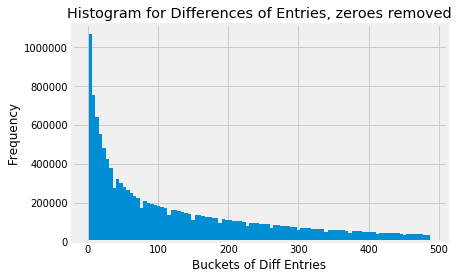

In [30]:
hist(IQ_rem_z,
     'diff_entry',
     'Histogram for Differences of Entries, zeroes removed',
     'Buckets of Diff Entries',
     'Frequency')

I'll need to dig a bit deeper to see if I should drop zero rows entirely.

In [31]:
IQ_rem[IQ_rem.diff_entry == 0][0:10]

,datetime,entries,exits,date,station_line_id,ts_id,diff_entry
2345767,2015-01-12 05:50:18,56263,20468,2015-01-12,135,0,0.0
2345674,2015-01-27 07:00:00,84983,27557,2015-01-27,135,0,0.0
2228958,2016-02-13 03:00:00,691629,212783,2016-02-13,135,0,0.0
2228957,2016-02-13 07:00:00,691629,212784,2016-02-13,135,0,0.0
2228786,2016-03-05 07:00:00,720978,224243,2016-03-05,135,0,0.0
2227895,2016-08-21 07:43:06,983358,316808,2016-08-21,135,0,0.0
2227894,2016-08-21 07:44:26,983358,316808,2016-08-21,135,0,0.0
5049670,2015-01-04 19:00:00,6032790,5333589,2015-01-04,287,1,0.0
5049668,2015-01-04 23:00:00,6032790,5333661,2015-01-04,287,1,0.0
5049666,2015-01-05 03:00:00,6032790,5333687,2015-01-05,287,1,0.0


From looking at the time the observations were recorded -- often, the middle of the night-- we see that not all 0 values are necessarily anomalous.

Now I turn to examine the very large values. If a turnstile was entered once every second for 6 hours -- which seems highly unlikely -- there would be a 21600 entrances. (I chose 6  arbitarily, for illustration, because that is usually greater than a timestamp difference.) Let's take a closer look at the entries greater than this value.

In [32]:
df_aug[df_aug.diff_entry > 21600][0:10]

,datetime,entries,exits,date,station_line_id,ts_id,diff_entry
2228241,2016-06-18 00:00:00,891643,284230,2016-06-18,135,0,24290.0
4805906,2016-06-18 00:00:00,7327700,6238309,2016-06-18,287,1,36041.0
4804893,2016-12-17 03:00:00,7769376,6545552,2016-12-17,287,1,23452.0
5415220,2016-06-18 02:07:12,147774,98224,2016-06-18,89,5,26254.0
2835852,2016-06-18 01:00:00,1606639,531188,2016-06-18,182,9,38186.0
2438209,2015-10-31 00:00:00,6009347,682441,2015-10-31,266,11,52897.0
2438166,2015-11-14 03:00:00,6113018,690292,2015-11-14,266,11,51421.0
2438124,2015-11-28 03:00:00,6203655,697983,2015-11-28,266,11,41003.0
4826614,2016-06-18 00:00:00,4269884,5405921,2016-06-18,87,17,27537.0
4763853,2016-06-18 01:00:00,4835790,2700914,2016-06-18,146,27,36759.0


In [33]:
df_aug[df_aug.diff_entry > 21600].shape[0]

3031

Let's look at one of the entries in more detail:

In [34]:
df_aug[ (df_aug.ts_id == 0) &
       (df_aug.date >= get_date("2016-06-03")) &
       (df_aug.date <= get_date("2016-06-18"))][0:10]

,datetime,entries,exits,date,station_line_id,ts_id,diff_entry
2228247,2016-06-03 00:00:00,865597,275169,2016-06-03,135,0,164.0
2228246,2016-06-03 04:00:00,865602,275176,2016-06-03,135,0,5.0
2228245,2016-06-03 08:00:00,865769,275238,2016-06-03,135,0,167.0
2228244,2016-06-03 12:00:00,866333,275361,2016-06-03,135,0,564.0
2228243,2016-06-03 16:00:00,866740,275501,2016-06-03,135,0,407.0
2228242,2016-06-03 20:00:00,867353,275774,2016-06-03,135,0,613.0
2228241,2016-06-18 00:00:00,891643,284230,2016-06-18,135,0,24290.0
2228240,2016-06-18 04:00:00,891653,284234,2016-06-18,135,0,10.0
2228239,2016-06-18 08:00:00,891669,284252,2016-06-18,135,0,16.0
2228238,2016-06-18 12:00:00,891788,284326,2016-06-18,135,0,119.0


Some of large values follow the above pattern, where there are dates missing and then a sudden jump, as if the data for the previous days were collected all at once. However, this does not explain all the large value anomalies, since many do not follow this pattern. With more time, we could find patterns like this and create rules to scrub the data more finely. But there are many approaches to dealing with the anomalous data. This is what I would try next:

* Normalize the timestamps so they are uniform,
* estimate more carefully the physical maximum of entries into a turnstile for the timestamps, and remove the entries that exceed those,
* consider only keeping turnstiles that have shown reasonable behavior across all time, depending on how much data that leaves,
* look for patterns that indicate a turnstile is broken besides 0 ridership at a timestamp.

In the interest of time, however I did something quick and dirty that leads to high performance later. Specifically, I used a `z-score`, across all data, including the test set (the data to be forecast) of December 2016. I was hoping for a normal distribution of the entry differences, so that this approach was more appropriate, but an alternative approach was not as performant (a modified z-score based on the median).

There are multiple stages at which can remove anomalies, at different smoothing levels (i.e., at different thresholds of z-score). To be systematic, the following needs to be optimized, replacing the "?"'s with optimal threshold values.


|                                | Across all stations data | Individual stations data |
|--------------------------------|--------------------------|--------------------------|
| Across consecutive differences | ?                        | ?                        |
| Across total entries           | ?                        | ?                        | 



I expect the performance of modeling to initially improve if I remove outliers, but then degrade if I smooth too much. One reason for the degradation would be the existence of seasonality patterns in the data, so the peaks and valleys could be removed with too much smoothing.

I will use the function below to remove outliers.

In [35]:
def remove_outliers(df, outlier_column_name, drop_anomalies=False, threshold=3):
    """
    Given a dataframe, remove outliers from a given column, according to some threshold. 
    Return a dataframe.
    """
    z_name = outlier_column_name + '_z'
    df[z_name] = df[[outlier_column_name]].apply(zscore)
    initial = df.shape[0]
    df = df[(abs(df[z_name] )< threshold)]
    df = df.drop(z_name, axis=1)
    after = initial - df.shape[0]
    print(f"{after} outliers for {outlier_column_name} have been removed")
    return df

We do a gentle smoothing on the consecutive differences now, since between two consecutive timestamps huge jumps are likely to be anomalous. I noticed that removing anomalies at this stage improves modeling performance later. In future work, this would be an optimization parameter for a grid search.

In [36]:
df_aug = remove_outliers(df_aug, 'diff_entry', drop_anomalies=True, threshold=3)
df_aug = remove_outliers(df_aug, 'diff_entry', drop_anomalies=True, threshold=3)
df_2016 = remove_outliers(df_2016, 'diff_entry', drop_anomalies=True, threshold=3)

351 outliers for diff_entry have been removed
1436 outliers for diff_entry have been removed
184 outliers for diff_entry have been removed


Now we finally get the daily entries for each turnstile id, by performing a groupby operation; we add in the 'station_line_id' because we'd like to keep track of that for the next aggregation.

In [37]:
def sum_daily_entries(df):
    """
    By summing differences in timestamps for each day, get the daily entries.
    Inputs and outputs a dataframe.
    """
    df = df.groupby(['ts_id', 'date', 'station_line_id'], as_index=False)['diff_entry'].sum()
    df = df.reset_index(drop=True)
    df = df.rename(columns={'diff_entry':'daily_entry'})
    return df

In [38]:
df_aug = sum_daily_entries(df_aug)
df_2016 = sum_daily_entries(df_2016)

The problem statement requires us to do forecasting of ridership in two types of granularity: across all stations, and then for each  station. We again do this for both the full 2015-2016 data, and just the 2016 one, for later comparisons

In [39]:
def df_by_stations(df):
    return df.groupby(['date', 'station_line_id'], as_index=False)['daily_entry'].sum()

def df_across_all_stations(df):
    return df.groupby(['date'], as_index=False)['daily_entry'].sum()


In [40]:
df_by_stations_aug = df_by_stations(df_aug)
df_by_stations_2016 = df_by_stations(df_2016)

df_across_all_stations_aug = df_across_all_stations(df_by_stations_aug)
df_across_all_stations_2016 = df_across_all_stations(df_by_stations_2016)

In [41]:
df_across_all_stations_aug.head()

,date,daily_entry
0,2015-01-01,2227383.0
1,2015-01-02,4506532.0
2,2015-01-03,3062739.0
3,2015-01-04,2476774.0
4,2015-01-05,5639868.0


In [42]:
df_by_stations_aug.head()

,date,station_line_id,daily_entry
0,2015-01-01,0,5973.0
1,2015-01-01,1,6799.0
2,2015-01-01,2,3679.0
3,2015-01-01,3,2195.0
4,2015-01-01,6,4156.0


Finally, let's plot the consecutive differences rather than the absolute numbers.

In [43]:
def get_differences_del(df):
    df.sort_values('date', inplace=True)
    
    df['diff_entry'] = df['daily_entry'].diff().reset_index(level=0, drop=True)
    df.dropna(inplace=True)
    
    return df

In [44]:
df_across_all_stations_aug = get_differences_del(df_across_all_stations_aug)

In the plot below, we observe the differences oscillate around 0. Despite the fact that we already removed some outliers for the consecutive differences, there could be more to remove at the differences stage, considering these spikes. However, we move on, and address these spikes indirectly with outlier removal for the daily entries before the modeling process.

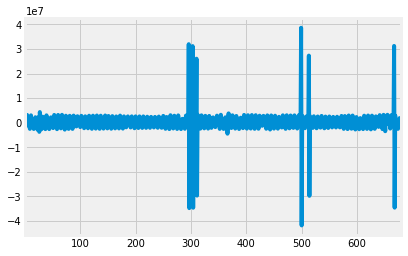

In [45]:
df_across_all_stations_aug['diff_entry'].plot()

## Understanding the Data from a Time Series POV

Now that we have processed the data, we will show some plots that illustrate seasonality. 

We choose an arbitrary station and date range to illustrate  weekly seasonality. The dips occur at weekend days.

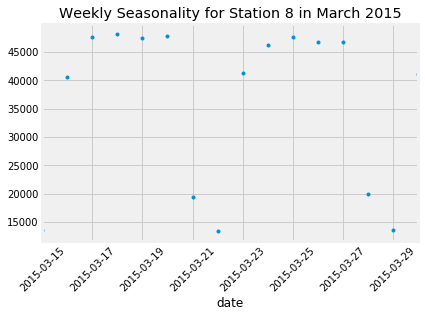

In [46]:
df_by_stations_aug.set_index('date', inplace=True)
df_by_stations_aug[(df_by_stations_aug.station_line_id == 8) 
                  & (df_by_stations_aug.index < get_date("03-31-2015")) 
                 & (df_by_stations_aug.index > get_date("03-14-2015"))]['daily_entry'].plot(style='.',
                                                                                            rot=45,
                                                                                            title='Weekly Seasonality for Station 8 in March 2015')
df_by_stations_aug.reset_index(inplace=True)

Next, we plot all the data, to see if we can discern a yearly trend. We need further smooth the data to see any meaningful patterns. We'll do this on a separate copy of the data, since we are still just performing visualizations.

There is no discernible upwards or downwards linear trend across the two years. There is some degree of yearly seasonality: a year has roughly the shape of an upside down W, with ridership dipping in the summer months and around the new year.

11 outliers for daily_entry have been removed


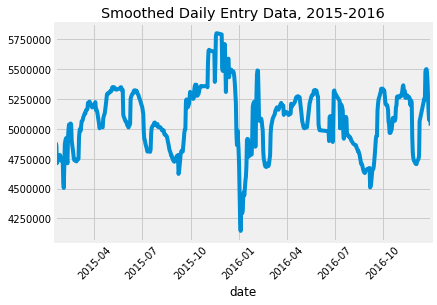

In [47]:
def rolling_mean_entry(df, label, rolling_mean_window=3):
    df_label= pd.DataFrame(df[label].copy())
    window = df_label.shift(1).rolling(window=rolling_mean_window)
    df['rolling_mean_entry'] = round(window.mean(), 4)
    df.dropna(inplace=True)
    return df


df_across_all_stations_aug_rem = remove_outliers(df_across_all_stations_aug,
                                             'daily_entry',
                                             drop_anomalies=True,
                                            threshold=1)
rol_df_across_all_stations_aug = rolling_mean_entry(df_across_all_stations_aug_rem,
                                                    'daily_entry',
                                                    rolling_mean_window=14)
rol_df_across_all_stations_aug.set_index('date', inplace=True)
rol_df_across_all_stations_aug['rolling_mean_entry'].plot(rot=45, title='Smoothed Daily Entry Data, 2015-2016')
rol_df_across_all_stations_aug.reset_index(inplace=True)

Let's perform some basic statistics on the two years. We will see that the mean and variances are similar for both, which suggests possible stationarity in the absence of random noise. Future scope would be to perform statistical tests that provide the likelihood of stationarity. 

In [48]:
rd = df_across_all_stations_aug_rem

In [49]:
def basic_array_stats(x):
    norm2 = normalize(x[:,np.newaxis], axis=0).ravel()
    return stats.describe(norm2)


In [50]:
x_2015 = rd[ (rd.date > get_date("2015-01-01")) & (rd.date < get_date("2015-12-31"))]['daily_entry']
x_2016 = rd[ (rd.date > get_date("2016-01-01")) & (rd.date < get_date("2016-12-31"))]['daily_entry']


In [51]:
basic_array_stats(x_2015)


DescribeResult(nobs=323, minmax=(0.02363088544803289, 0.06803130883161539), mean=0.05393181622950416, variance=0.00018791621433043024, skewness=-0.8268117226127046, kurtosis=-1.0001980790024882)

In [52]:
basic_array_stats(x_2016)

DescribeResult(nobs=330, minmax=(0.023014398765173586, 0.06731975496147923), mean=0.05328156441239499, variance=0.0001919596198886793, skewness=-0.8484829114939049, kurtosis=-0.9664981784872726)

# Modeling

Here are a collection of functions I wrote for the purpose of modeling. The actual modeling begins below.

In the code, we implement the following features:
- Shift (lag) features indicating previous days' ridership. The window of the lag is something one can optimize on as well. This helps us include near-term data for predictions.
- Rolling mean (similar reasoning as the lag above)
- Holiday feature (plus lags, since ridership can dip around a window of an official holiday, such as Christmas)
- Datetime features (to account for seasonality trends)

## Functions

In [53]:
def split_df_train_test(df, start_date, split_date, end_date='01-01-2020'):
    """
    Given a dataframe, a start date, a split date, and an end date, split the dataframe
    into test and training dataframes.
    """
    df.set_index("date", inplace=True)
    
    start_date =  get_date(start_date)
    split_date = get_date(split_date)
    end_date = get_date(end_date)
    assert (start_date < split_date) & (split_date < end_date), "Incorrectly formatted dates"
    df_train = df.loc[(df.index > start_date) & (df.index <= split_date)].copy()
    df_test = df.loc[(df.index > split_date) & (df.index <= end_date)].copy()

    df_train.reset_index(inplace=True)
    df_test.reset_index(inplace=True)
    
    return df_train, df_test


In [54]:
def train_plot_eval(df, start_date, split_date,
                    outlier_threshold=False,
                    end_date='01-01-2020',
                    label='daily_entry',
                    shift_start=2,
                    shift_end=6,
                    rolling_mean_window=3,
                    by_station=False,
                    plot_n_random_stations=False,
                    incl_holidays=True,
                    plot=False,
                    evaluate=True ):
    
    """
    Main function that ties together training and evaluation.
    """
    df = df.copy()
    # Split training & testing sets by day
    
    if outlier_threshold:
        df = remove_outliers(df, label, drop_anomalies=True, threshold=outlier_threshold)

    df_train, df_test = split_df_train_test(df, start_date, split_date, end_date)
    
    # Create feature training and test sets
    X_train, y_train = create_features(df_train, label, shift_start, shift_end,
                                       rolling_mean_window, by_station, incl_holidays)
    X_test, y_test = create_features(df_test, label, shift_start, shift_end,
                                     rolling_mean_window, by_station, incl_holidays)
    
    # Train the model using xgboost
    model = train_xgb_model(X_train, y_train, X_test, y_test)    
    
    if evaluate:
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        
        if not by_station:
            X_test.reset_index(inplace=True)
            predictions_str = [str(x) for x in predictions]
            dates = [str(x.date()) for x in X_test.date]
            differences = [str(x) for x in abs(y_test - predictions)]
            y_test_str = [str(x) for x in y_test]
            print("DATE      PREDICTION ACTUAL   DIFF")
            for row in zip(dates, predictions_str, y_test_str, differences):
                print(' '.join(row))
            X_test.set_index("date", inplace=True)
        
        df_test['test_pred'] = predictions
        performance_measures(df_test, y_test, by_station, predictions)
        worst_days(df_test, by_station)
        
    if plot:
        show_test_set(df_train, df_test)
        _ = plot_importance(model, height=0.9)
        if plot_n_random_stations:
            plot_forecasts(df_test, X_test, model, split_date, end_date, plot_n_random_stations)
        else:
            plot_forecasts(df_test, X_test, model, split_date, end_date)
    

In [55]:
def worst_days(df_test, by_station=False):
    
    """
    For use in evaluation, given the test set, print the days the model performs the worst on.
    """
    
    print("*"*70)
    print("The model's predictions were the most erroneous on these days:")
    df_test['error'] = df_test['daily_entry'] - df_test['test_pred']
    df_test['abs_error'] = df_test['error'].apply(np.abs)
    gb = ['year','month','dayofmonth']
    if by_station:
        gb.append('station_line_id')
    error_by_day = df_test.groupby(gb).mean()[['daily_entry','test_pred','error','abs_error']]
    print(error_by_day.sort_values('error', ascending=True).head(5))
    print("*"*70)
    
def performance_measures(df_test, y_test, by_station, predictions):
    """
    Prints performance metrics.
    First, prints the R^2 score.
    Then, calculates the mean absolute error, and the normalized version, where it is divided
    by average ridership per day in the test set, either by station, or across all stations.
    """
    print("*"*70)
    print("PERFORMANCE METRICS")
    r2score = round(r2_score(y_test, predictions), 4)
    print(f"The R2 score is {r2score}")
    
    # OTHER POSSIBILITIES FOR METRICS, WHICH I COMMENT OUT TO FOCUS ON MEAN ABSOLUTE ERROR
    # mae = round(median_absolute_error(y_test, predictions), 4)
    # print(f"The median absolute error is {mae}")
    # meansqe = round(mean_squared_error(y_test, predictions), 4)
    # print(f"The mean squared error is {meansqe}")   
    
    if by_station:
        df_test.reset_index(inplace=True)
        av_by_station = np.mean(df_test.groupby(['station_line_id', 'date'])['daily_entry'].sum())
        df_test.set_index('date', inplace=True)
        
        meanae = round(mean_absolute_error(y_test, predictions), 4)
        norm = round((meanae / av_by_station*1.0) * 100 , 2)
        print(f"The mean absolute error is {meanae} entries, for an error of {norm} percent")

    else:
        df_test.reset_index(inplace=True)
        av_across_station = np.mean(df_test.groupby('date')['daily_entry'].sum())
        df_test.set_index('date', inplace=True)

        meanae = round(mean_absolute_error(y_test, predictions), 4)
        norm = round((meanae / av_across_station*1.0) * 100 , 2)
        print(f"The mean absolute error is {meanae} entries, for an error of {norm} percent")


def show_test_set(df_train, df_test):
    """
    Display the proportion of the test set vs. the total set
    """
    df_all = pd.concat([df_test, df_train], sort=False)
    _ = df_all[['daily_entry','test_pred']].plot(figsize=(15, 5), title="Train/test Split")


In [56]:
def train_xgb_model(X_train, y_train, X_test, y_test):
    """
    Trains an XGBoost model with the default settings
    """
    reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror')
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            early_stopping_rounds=50,
           verbose=False) 
    return reg

In [57]:
def column_shift(df, shift_start, shift_end, label, column_names = []):
    """
    Creates lag or shift features for a given column in a dataframe
    """
    df_label= pd.DataFrame(df[label].copy())
    df_label.columns = ["y"]
    for i in range(shift_start, shift_end):
        df[label + "_shift_{}".format(i)] = df_label.y.shift(i)
        column_names.append(label + "_shift_{}".format(i))
    return column_names


In [58]:
def create_features(df, label, shift_start, shift_end, rolling_mean_window, by_station=False, incl_holidays=True):
    """
    Ties together the feature engineering
    """
    
    #Create time series features from datetime index
    df.reset_index(inplace=True)
    df['date'] = pd.to_datetime(df.date)
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofmonth'] = df['date'].dt.day
    df['isweekend'] = df['date'].dt.weekday.isin([5,6])*1
    df.set_index('date', inplace=True)
    keep_columns = ['dayofweek','month','year',
                    'dayofmonth', 'isweekend', 'rolling_mean_entry']
    if by_station:
        keep_columns.append('station_line_id')
        
    
    # add shifted features
    keep_columns = column_shift(df, shift_start, shift_end, label, column_names = keep_columns)
    
    # add holiday features
    if incl_holidays:
        df.reset_index(inplace=True)
        def is_holiday(date):
            return get_date(date) in us_holidays
        df["is_holiday"] = df["date"].apply(is_holiday)*1
        keep_columns = column_shift(df, 1, 4, 'is_holiday', column_names = keep_columns)
        keep_columns.append("is_holiday")
        df.set_index('date', inplace=True)
    
    # calculate rolling mean averages 
    df_label= pd.DataFrame(df[label].copy())
    window = df_label.shift(1).rolling(window=rolling_mean_window)
    df['rolling_mean_entry'] = round(window.mean(), 4)
    df.dropna(inplace=True)
    X = df[keep_columns]
    y = df[label]
    return X, y


In [59]:
def plot_forecasts(df, X_test, model, start_timestamp, end_timestamp, plot_n_random_stations=False):
    """
    Plots the forecast against the actual data
    """
    
    if plot_n_random_stations:
        stations = random.sample(list(df.station_line_id.unique()), plot_n_random_stations)
        len_si = plot_n_random_stations
        fig, axes = plt.subplots(len_si, 1, sharex=True)
        fig.set_figheight(5*len_si)
        fig.set_figwidth(15)
        if len_si == 1:
                df_0 = df[df.station_line_id == stations[0]]
                _ = df_0[['test_pred','daily_entry']].plot(ax=axes,
                                                          style=['-','.'])
                axes.set_xlim(pd.Timestamp(start_timestamp), pd.Timestamp(end_timestamp))
                axes.set_title("Forecasting Station {}".format(stations[0]))

        else:
            for i in range(len_si):
                df_i = df[df.station_line_id == stations[i]]
                _ = df_i[['test_pred','daily_entry']].plot(ax=axes[i],
                                                          style=['-','.'])
                axes[i].set_xlim(pd.Timestamp(start_timestamp), pd.Timestamp(end_timestamp))
                axes[i].set_title("Forecasting Station {}".format(stations[i]))

    else:
        f, ax = plt.subplots(1)
        _ = df[['test_pred','daily_entry']].plot(ax=ax,
                                                  style=['-','.'])

        ax.set_xlim(pd.Timestamp(start_timestamp), pd.Timestamp(end_timestamp))
        
    plot = plt.suptitle('Forecast vs Actuals')



## Part A: Modeling Across all Stations

We now train the model in 5 different ways, sequentially.

Our first model (#1) is the 2016 turnstile data, with no outliers removed, and no holiday features. We get improvements by augmenting with 2015 data and with holiday features.

Interestingly, the R^2 drops from model 2 to model 3 as we introduce holiday features. In the absence of previous years' dates, it appears that the model is overcompensating for holiday features, which can be seen by comparing the forecast plots between 2 and 3. In particular, the model is less accurate on non-holidays.

However, thanks to yearly seasonality, in the end the holiday feature does improve performance for the augmented data.

Here are the summary of results:

|                  | 1     | 2    | 3    | 4    | 5    |
|------------------|-------|------|------|------|------|
| Outlier removal  |       | Y    | Y    | Y    | Y    |
| Holiday features |       |      | Y    |      | Y    |
| Augmented 2015   |       |      |      | Y    | Y    |
| R^2              | -.068 | .842 | .829 | .876 | .960 |

One important caveat: the outlier removal is not constant across the trainings, because there are different optimal ones. Since the model trains so quickly, I was able to manually test different possibilities and chose the best based on R^2 performance. Given more time, I'd implement a grid search to automate it.


Finally, if we want to train day by day as the problem statement suggests, we would simply run:

`train_plot_eval(df,
                start_date=START_DATE,
                split_date=UP_TO_DAY,
                end_date=UP_TO_DAY+1)`              
The output will print out the difference between the actual result and the predicted one for `UP_TO_DAY + 1`, as well as other performance measures.


### #1

DATE      PREDICTION ACTUAL   DIFF
2016-12-06 5788818.0 6257833.0 469015.0
2016-12-07 6144485.0 6243510.0 99025.0
2016-12-08 6169184.0 6456614.0 287430.0
2016-12-09 5799726.0 6913444.0 1113718.0
2016-12-17 4733962.0 40501118.0 35767156.0
2016-12-18 5095397.0 2912498.0 2182899.0
2016-12-19 6711378.0 5832408.0 878970.0
2016-12-20 6121252.0 6014852.0 106400.0
2016-12-21 5933724.0 5934662.0 938.0
2016-12-22 5998116.0 5725659.0 272457.0
2016-12-23 5840257.0 5170502.0 669755.0
2016-12-24 4424048.0 2682761.0 1741287.0
2016-12-25 3016577.0 1901361.0 1115216.0
2016-12-26 5992904.0 3525227.0 2467677.0
2016-12-27 5992904.0 4693798.0 1299106.0
2016-12-28 7709264.0 5057375.0 2651889.0
2016-12-29 5540830.0 4718714.0 822116.0
2016-12-30 5745965.0 4957076.0 788889.0
**********************************************************************
PERFORMANCE METRICS
The R2 score is -0.068
The mean absolute error is 2929663.5 entries, for an error of 42.02 percent
*************************************************

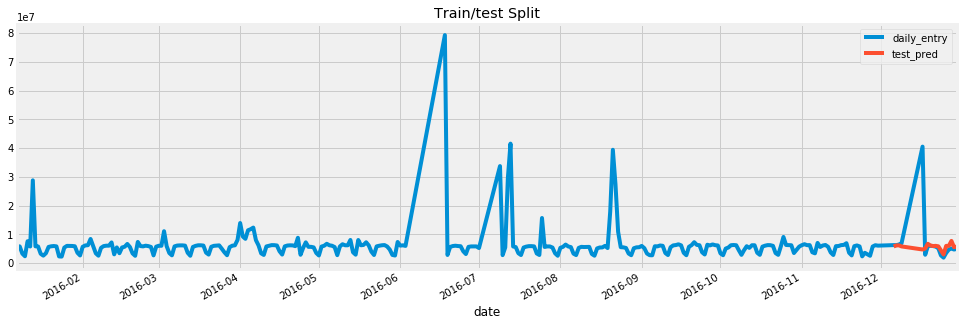

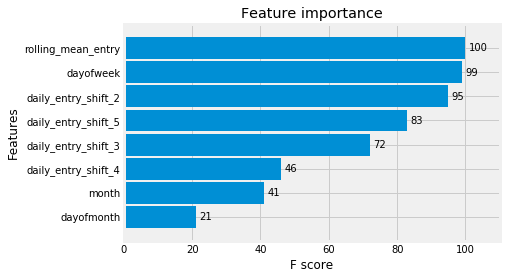

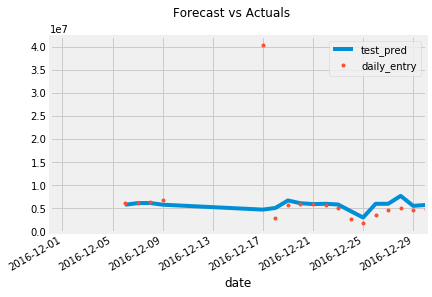

In [60]:
train_plot_eval(df_across_all_stations_2016,
                start_date="01-01-2016",
                split_date="11-30-2016",
                end_date="12-30-2016",
                incl_holidays=False,
                plot=True)


### #2

11 outliers for daily_entry have been removed
DATE      PREDICTION ACTUAL   DIFF
2016-12-06 6051700.0 6257833.0 206133.0
2016-12-07 6507142.0 6243510.0 263632.0
2016-12-08 6043787.0 6456614.0 412827.0
2016-12-09 5809696.0 6913444.0 1103748.0
2016-12-18 2851184.0 2912498.0 61314.0
2016-12-19 5777987.0 5832408.0 54421.0
2016-12-20 6186346.0 6014852.0 171494.0
2016-12-21 6063118.0 5934662.0 128456.0
2016-12-22 5873397.0 5725659.0 147738.0
2016-12-23 5194248.0 5170502.0 23746.0
2016-12-24 3166110.0 2682761.0 483349.0
2016-12-25 2599455.0 1901361.0 698094.0
2016-12-26 4768620.0 3525227.0 1243393.0
2016-12-27 5666506.0 4693798.0 972708.0
2016-12-28 4614642.0 5057375.0 442733.0
2016-12-29 4762958.0 4718714.0 44244.0
2016-12-30 5532614.0 4957076.0 575538.0
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.8424
The mean absolute error is 413739.2941 entries, for an error of 8.27 percent
**************************************************

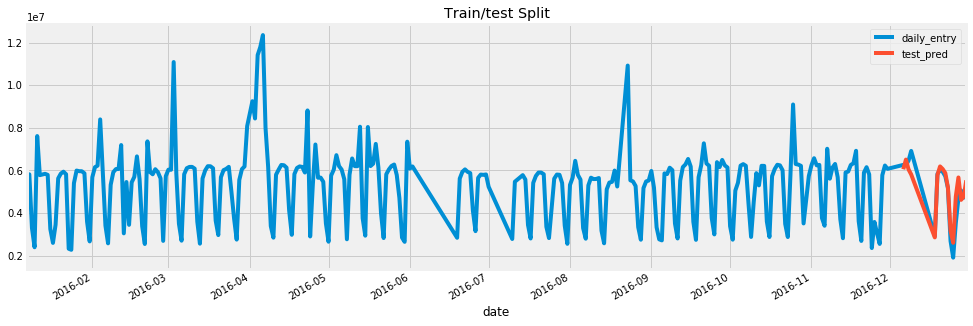

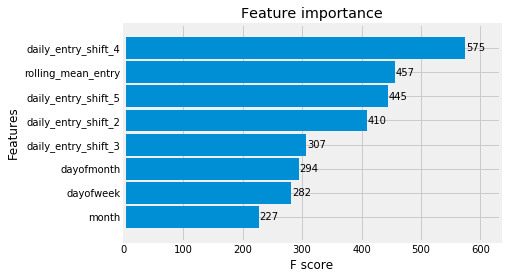

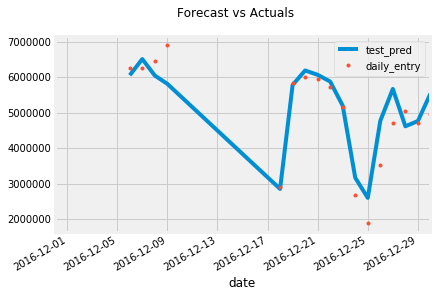

In [61]:
train_plot_eval(df_across_all_stations_2016,
                start_date="01-01-2016",
                split_date="11-30-2016",
                end_date="12-30-2016",
                incl_holidays=False,
                plot=True,
                outlier_threshold=1.2)


### #3

11 outliers for daily_entry have been removed
DATE      PREDICTION ACTUAL   DIFF
2016-12-06 5701094.0 6257833.0 556739.0
2016-12-07 5756156.0 6243510.0 487354.0
2016-12-08 5893662.0 6456614.0 562952.0
2016-12-09 5814818.0 6913444.0 1098626.0
2016-12-18 3262603.0 2912498.0 350105.0
2016-12-19 5977708.0 5832408.0 145300.0
2016-12-20 5761183.0 6014852.0 253669.0
2016-12-21 5761183.0 5934662.0 173479.0
2016-12-22 5976294.0 5725659.0 250635.0
2016-12-23 5482540.0 5170502.0 312038.0
2016-12-24 3233367.0 2682761.0 550606.0
2016-12-25 2675597.0 1901361.0 774236.0
2016-12-26 3273716.0 3525227.0 251511.0
2016-12-27 5671920.0 4693798.0 978122.0
2016-12-28 5635936.0 5057375.0 578561.0
2016-12-29 5624495.0 4718714.0 905781.0
2016-12-30 5430454.0 4957076.0 473378.0
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.829
The mean absolute error is 511946.5882 entries, for an error of 10.24 percent
***********************************************

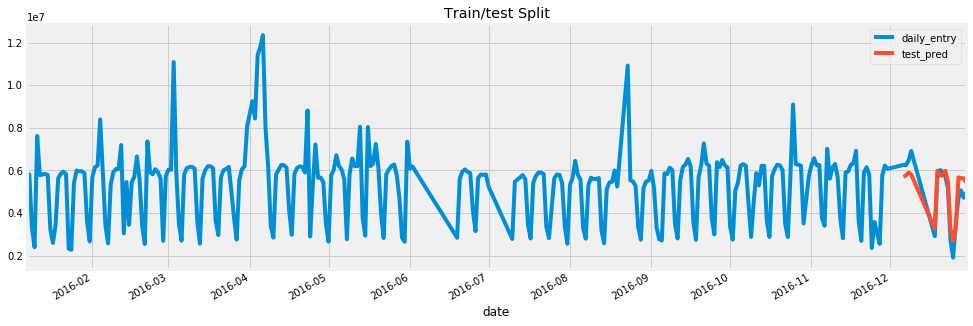

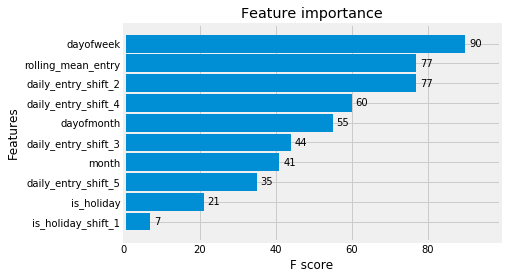

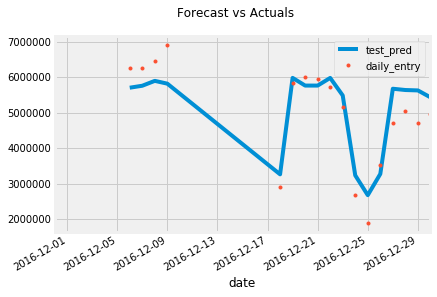

In [62]:
train_plot_eval(df_across_all_stations_2016,
                start_date="01-01-2016",
                split_date="11-30-2016",
                end_date="12-30-2016",
                incl_holidays=True,
                plot=True,
                outlier_threshold=1.2)

### #4

In [63]:
train_plot_eval(df_across_all_stations_aug,
                start_date="01-01-2015",
                split_date="11-30-2016",
                end_date="12-30-2016",
                incl_holidays=False,
                plot=False,
                outlier_threshold=1.3)

6 outliers for daily_entry have been removed
DATE      PREDICTION ACTUAL   DIFF
2016-12-06 6142062.0 6257833.0 115771.0
2016-12-07 6268928.0 6243510.0 25418.0
2016-12-08 6372116.0 6333452.0 38664.0
2016-12-09 6134820.0 6244969.0 110149.0
2016-12-18 3258347.0 2912498.0 345849.0
2016-12-19 6045564.0 5832408.0 213156.0
2016-12-20 6050440.0 6014852.0 35588.0
2016-12-21 6145568.0 5934662.0 210906.0
2016-12-22 5752846.0 5725659.0 27187.0
2016-12-23 5269532.0 5170502.0 99030.0
2016-12-24 2857947.0 2682761.0 175186.0
2016-12-25 2361870.0 1901361.0 460509.0
2016-12-26 4649712.0 2814563.0 1835149.0
2016-12-27 4973599.0 4693798.0 279801.0
2016-12-28 5008222.0 5057375.0 49153.0
2016-12-29 4850944.0 4718714.0 132230.0
2016-12-30 4471740.0 4957076.0 485336.0
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.8758
The mean absolute error is 272887.1765 entries, for an error of 5.56 percent
******************************************************

### #5 (BEST)

6 outliers for daily_entry have been removed
DATE      PREDICTION ACTUAL   DIFF
2016-12-06 6135446.0 6257833.0 122387.0
2016-12-07 6291198.0 6243510.0 47688.0
2016-12-08 6285676.0 6333452.0 47776.0
2016-12-09 6277017.0 6244969.0 32048.0
2016-12-18 3124405.0 2912498.0 211907.0
2016-12-19 5987723.0 5832408.0 155315.0
2016-12-20 6039741.0 6014852.0 24889.0
2016-12-21 6139570.0 5934662.0 204908.0
2016-12-22 5831904.0 5725659.0 106245.0
2016-12-23 5520280.0 5170502.0 349778.0
2016-12-24 2985726.0 2682761.0 302965.0
2016-12-25 2384511.0 1901361.0 483150.0
2016-12-26 2118424.0 2814563.0 696139.0
2016-12-27 5168900.0 4693798.0 475102.0
2016-12-28 5111554.0 5057375.0 54179.0
2016-12-29 4924514.0 4718714.0 205800.0
2016-12-30 4832600.0 4957076.0 124476.0
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.9596
The mean absolute error is 214397.1765 entries, for an error of 4.37 percent
******************************************************

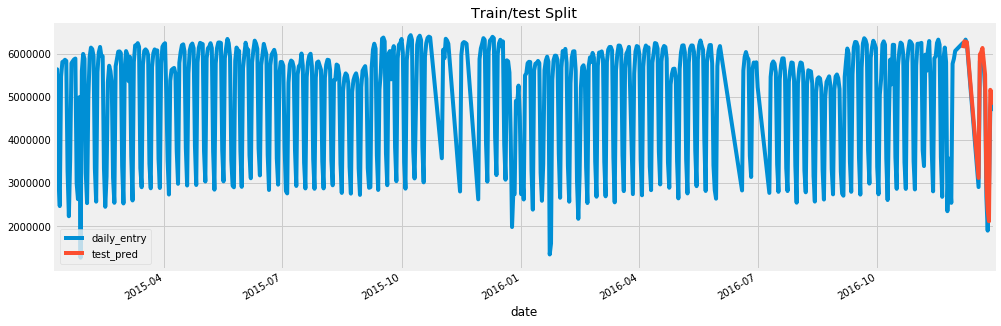

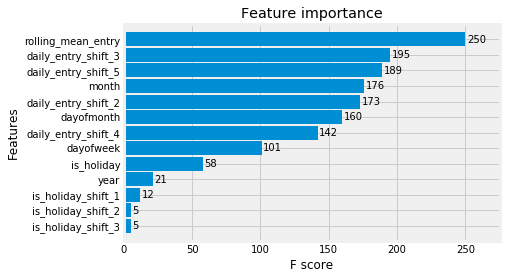

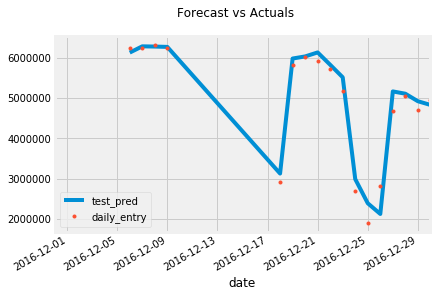

In [64]:
train_plot_eval(df_across_all_stations_aug,
                start_date="01-01-2015",
                split_date="11-30-2016",
                end_date="12-30-2016",
                incl_holidays=True,
                plot=True,
                outlier_threshold=1.4)

## Part B: Modeling by Each Station

Now we consider the by station problem.

I expected this problem to be "harder." My intuition was this: the previous work showed that performance highly sensitive to outlier removal. The best way to find anomalous points if we are modeling by station would be to do the performance optimization on threshold by station by station. As always, grid search for optimal outlier removal by station could do the trick.

This section is organized differently than the previous one. The holiday features improve the performance, so we include those without further comment. However,  in the by-station case, the performance is much better for just training on a month of data, versus training on the whole data. I went back and tried modeling only recent data for the all-station data, but the phenomenon of much better performance on recent data seems to just be occuring for the by-station data.

This suggests to me that the model is overfitting on station id, and underfitting on the near term fetures (shifts and rolling mean). A solution to this would be to modify the default weights in the xgboost model, to weigh near-term features more heavily and penalize the station_id more. Another possibility is an ensembling.

For illustrative purposes, we included the option of including random by-station plots.


15700 outliers for daily_entry have been removed
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.8528
The mean absolute error is 2043.7741 entries, for an error of 21.89 percent
**********************************************************************
The model's predictions were the most erroneous on these days:
                                       daily_entry  test_pred    error  \
year month dayofmonth station_line_id                                    
2016 12    2          445                   3230.0    24132.0 -20902.0   
           9          445                   3126.0    22874.0 -19748.0   
           1          492                   4013.0    19937.0 -15924.0   
           3          300                   2151.0    15122.0 -12971.0   
           4          206                      1.0    12419.0 -12418.0   

                                       abs_error  
year month dayofmonth station_line_id             
2016 1

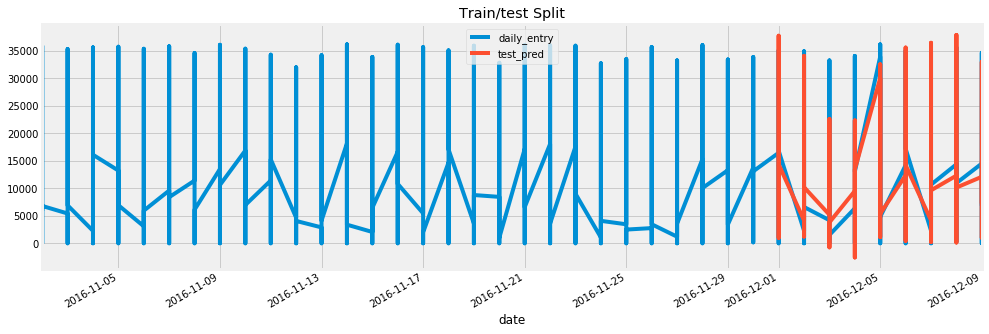

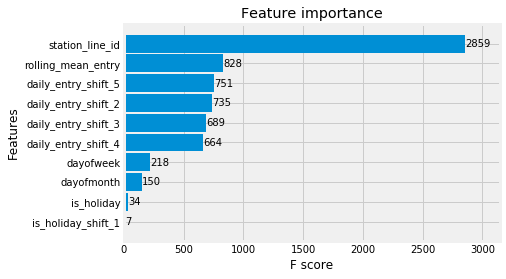

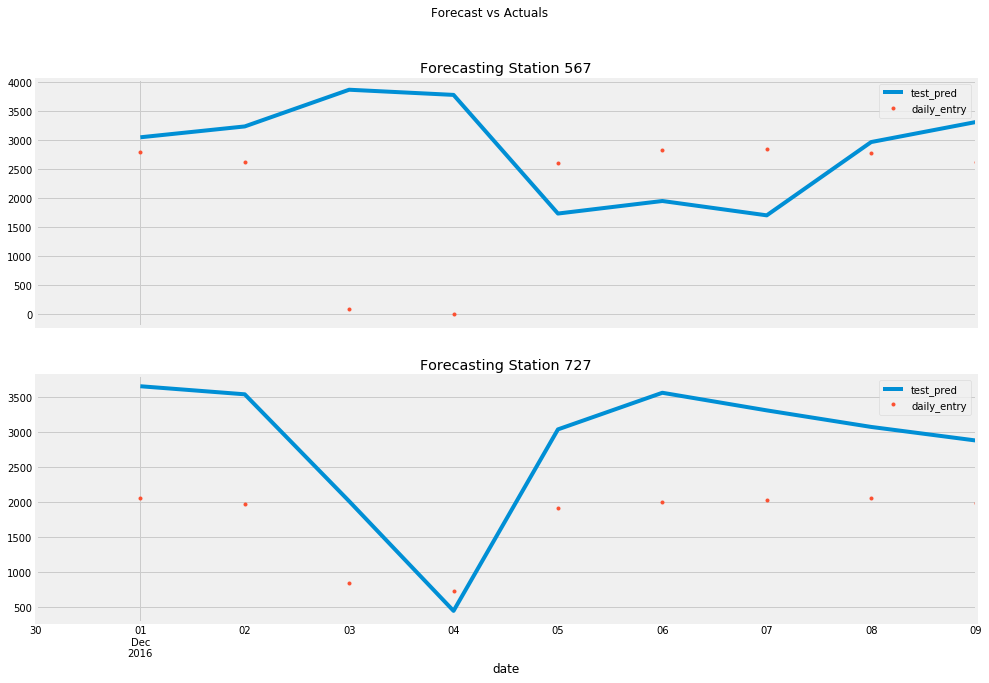

In [65]:
train_plot_eval(df_by_stations_aug,
                start_date="11-01-2016",
                split_date="11-30-2016",
                end_date="12-09-2016",
                incl_holidays=True,
                by_station=True,
                plot_n_random_stations=2,
                outlier_threshold=1.5,
                plot=True)

15700 outliers for daily_entry have been removed
**********************************************************************
PERFORMANCE METRICS
The R2 score is 0.709
The mean absolute error is 2849.646 entries, for an error of 30.52 percent
**********************************************************************
The model's predictions were the most erroneous on these days:
                                       daily_entry  test_pred    error  \
year month dayofmonth station_line_id                                    
2016 12    1          617                   5756.0    17576.0 -11820.0   
           7          617                   5772.0    17435.0 -11663.0   
           8          617                   5719.0    16517.0 -10798.0   
           1          492                   4013.0    14304.0 -10291.0   
           2          617                   5846.0    15790.0  -9944.0   

                                       abs_error  
year month dayofmonth station_line_id             
2016 12 

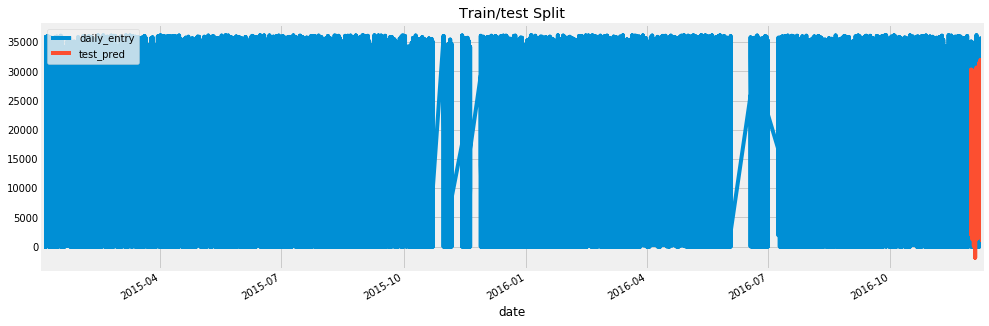

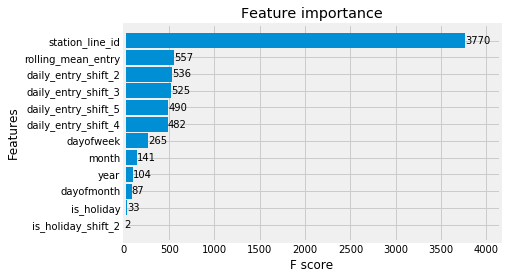

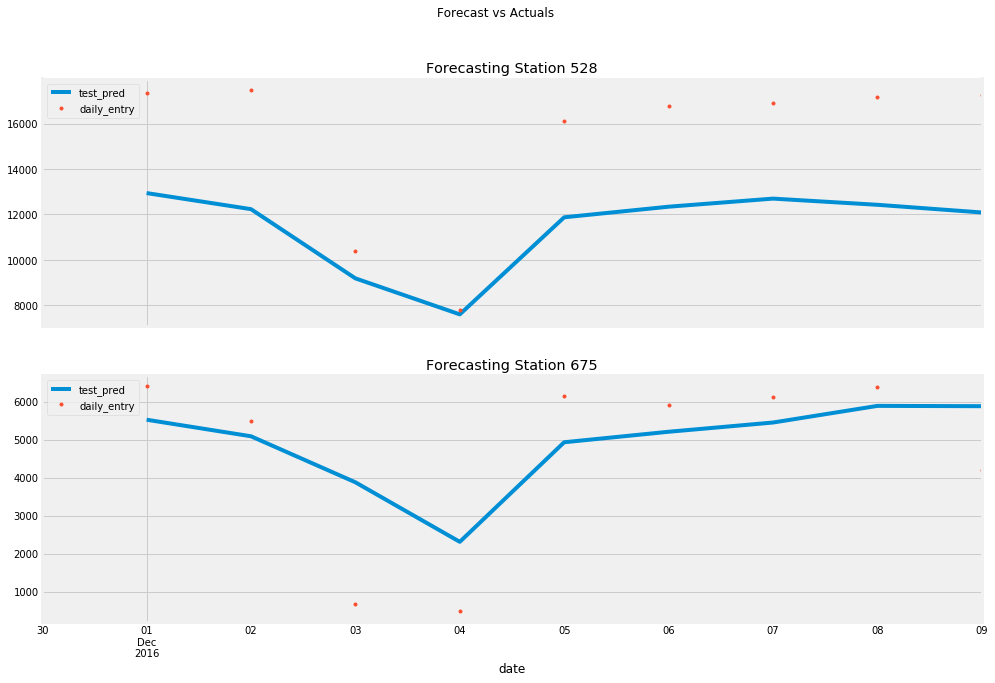

In [66]:
train_plot_eval(df_by_stations_aug,
                start_date="01-01-2015",
                split_date="11-30-2016",
                end_date="12-09-2016",
                incl_holidays=True,
                by_station=True,
                plot_n_random_stations=2,
                outlier_threshold=1.5,
                plot=True)

# Conclusion

Real-world public data can be challenging to use because it is often noisy. I began by exploring the data issues in the turnstile data, and implemented some solutions. I then explored the data from a statistical point of view, noting the weekly and yearly seasonality of the data, and hypothesized stationarity. Finally, I modeled the data across all stations, and for each station, using `xgboost`, achieving a high score once the data was cleansed and new features were added. 

In the future, here are some directions I'd explore:

- Perform **finer anomaly tuning:** Much of the model performance depended on anomaly removal, and I focused on optimizing the model on `R^2` rather than statistical rigorousness of the anomaly removal approach. I'd like to make the approach more rigorous, as well as perform a grid search to find the optimal thresholds for removing anomalies.

- Explore **other modeling approaches**, like `ARIMA`, especially for the by-station data.

- Perform **grid search** on XGboost parameters to find ones besides the default.

- Execute **time normalization** (rounding the timestamps for the data to be among 4 timestamps) that I implemented in the code above, and corresponding groupby in the `get_differences` function, in `Spark` on a cloud cluster. My local computer's processing power is too weak. Having that data would be useful for anomaly removal.

# **Thanks for reading! :)**